In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc, confusion_matrix
)

import joblib


In [4]:
df = pd.read_csv(r"C:\Users\SACHIN\OneDrive\Desktop\Final Mini Project\data\PS_transaction_log.csv",encoding='ISO-8859-1')
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df_train = df.copy()

# Remove labels for unsupervised training
if "isFraud" in df_train.columns:
    df_train.drop(columns=["isFraud"], inplace=True)

if "isFlaggedFraud" in df_train.columns:
    df_train.drop(columns=["isFlaggedFraud"], inplace=True)

print("Training columns:", df_train.columns.tolist())


Training columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest']


In [8]:
# Labeled data for evaluation
if "isFraud" not in df.columns:
    raise Exception("Dataset must contain isFraud for evaluation.")

df_eval = df.copy()
y_true = df_eval["isFraud"]
print("Fraud distribution:\n", y_true.value_counts())


Fraud distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [10]:
# Encode transaction type
le = LabelEncoder()
df_train["type_code"] = le.fit_transform(df_train["type"])
df_eval["type_code"] = le.transform(df_eval["type"])

# Derived features
df_train["balance_delta_org"] = df_train["newbalanceOrig"] - df_train["oldbalanceOrg"]
df_train["balance_delta_dest"] = df_train["newbalanceDest"] - df_train["oldbalanceDest"]

df_eval["balance_delta_org"] = df_eval["newbalanceOrig"] - df_eval["oldbalanceOrg"]
df_eval["balance_delta_dest"] = df_eval["newbalanceDest"] - df_eval["oldbalanceDest"]

features = [
    "amount",
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest",
    "step", "type_code",
    "balance_delta_org", "balance_delta_dest"
]

X_train = df_train[features].fillna(0)
X_eval = df_eval[features].fillna(0)

print("Training feature matrix:", X_train.shape)
print("Evaluation feature matrix:", X_eval.shape)


Training feature matrix: (6362620, 9)
Evaluation feature matrix: (6362620, 9)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

print("Scaling complete.")


Scaling complete.


In [12]:
model = IsolationForest(
    n_estimators=200,
    contamination=0.002,  
    max_samples='auto',
    random_state=42
)

model.fit(X_train_scaled)
print("Isolation Forest trained successfully.")


Isolation Forest trained successfully.


In [14]:
# -1 → anomaly | 1 → normal
pred_if = model.predict(X_eval_scaled)

df_eval["pred_label"] = np.where(pred_if == -1, 1, 0)  # 1 = suspicious
df_eval["score"] = -model.decision_function(X_eval_scaled)  # higher = more suspicious

df_eval[["isFraud", "pred_label", "score"]].head(10)


,isFraud,pred_label,score
0,0,0,-0.316905
1,0,0,-0.339855
2,1,0,-0.309073
3,1,0,-0.330589
4,0,0,-0.334581
5,0,0,-0.335601
6,0,0,-0.316719
7,0,0,-0.316063
8,0,0,-0.344152
9,0,0,-0.320807


In [15]:
y_pred = df_eval["pred_label"]
scores = df_eval["score"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

# AUC
roc_auc = roc_auc_score(y_true, scores)
print("ROC-AUC:", roc_auc)

# PR-AUC
precision, recall, _ = precision_recall_curve(y_true, scores)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.9968580553294083
Precision: 0.037246581801037244
Recall: 0.057713381224887374
F1-score: 0.045274368403457665
ROC-AUC: 0.8638808580554904
PR-AUC: 0.013168276949891087

Confusion Matrix:
 [[6342155   12252]
 [   7739     474]]


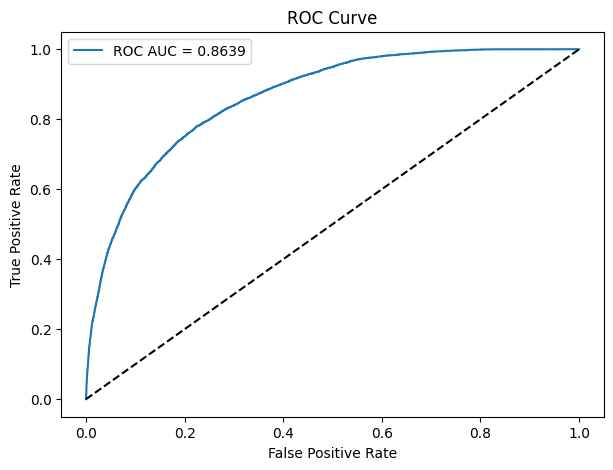

In [16]:
fpr, tpr, _ = roc_curve(y_true, scores)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


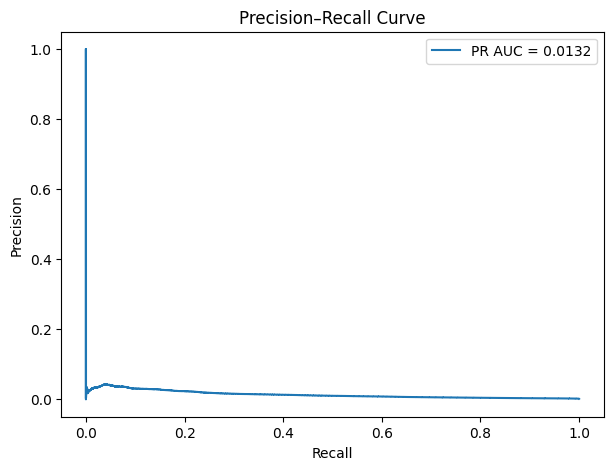

In [17]:
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


C:\Users\SACHIN\AppData\Local\Temp\ipykernel_1784\1496730839.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_eval[df_eval["isFraud"]==0]["score"], label="Normal", shade=True)
C:\Users\SACHIN\AppData\Local\Temp\ipykernel_1784\1496730839.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_eval[df_eval["isFraud"]==1]["score"], label="Fraud", shade=True)


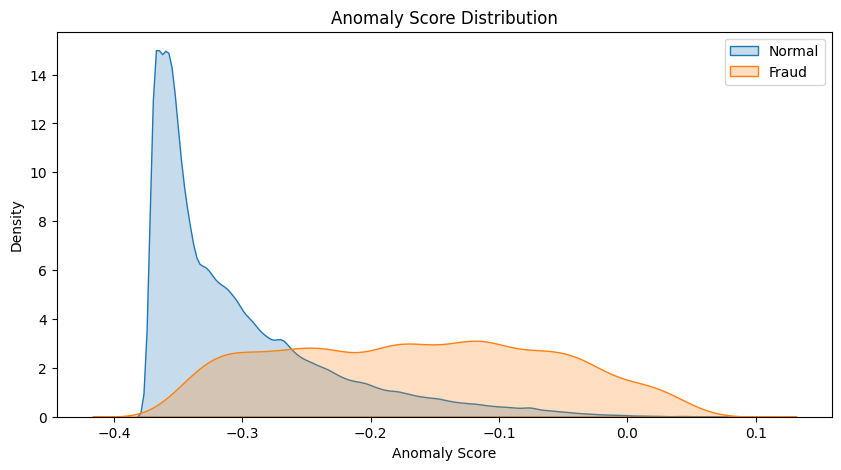

In [18]:
plt.figure(figsize=(10,5))
sns.kdeplot(df_eval[df_eval["isFraud"]==0]["score"], label="Normal", shade=True)
sns.kdeplot(df_eval[df_eval["isFraud"]==1]["score"], label="Fraud", shade=True)
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.legend()
plt.show()


In [19]:
for pct in [95, 98, 99, 99.5, 99.9]:
    thr = np.percentile(df_eval["score"], pct)
    preds = (df_eval["score"] >= thr).astype(int)

    p = precision_score(y_true, preds, zero_division=0)
    r = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)

    print(f"Threshold @ {pct}% | Precision={p:.4f} | Recall={r:.4f} | F1={f1:.4f} | Flagged={preds.sum()}")


Threshold @ 95% | Precision=0.0114 | Recall=0.4423 | F1=0.0223 | Flagged=318131
Threshold @ 98% | Precision=0.0172 | Recall=0.2665 | F1=0.0323 | Flagged=127253
Threshold @ 99% | Precision=0.0237 | Recall=0.1840 | F1=0.0421 | Flagged=63627
Threshold @ 99.5% | Precision=0.0297 | Recall=0.1151 | F1=0.0472 | Flagged=31814
Threshold @ 99.9% | Precision=0.0374 | Recall=0.0290 | F1=0.0327 | Flagged=6364


In [20]:
joblib.dump(model, "model_if.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "type_encoder.pkl")

print("Model, scaler, and encoder saved successfully!")


Model, scaler, and encoder saved successfully!
